In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pprint
import math
plt.rcParams['figure.figsize'] = [5, 5]

class Cell():
    '''Class defining individual cells with positional and biological attributes.'''
    def __init__(self, pos, t_birth = 0, radius = 1, parent = 0, concs = None):
        self.ID = len(allcells)
        self.pos = np.array(pos).reshape(2,1)
        self.alive = True
        self.rad = radius
        self.birth_rad = radius
        self.tbirth = t_birth
        self.parent = parent
        self.lt = 0
        self.concs = concs
        allcells.append(self)
           
    def dist(self, othercell):
        dist = np.sqrt(np.sum(np.square(self.pos - othercell.pos)))
        return dist
    
    def divide(self, time):
        '''Eliminates the cell and creates two daughter cells with the same parent, concentrations/2.'''
        # eliminate the cell
        self.alive = False
        # divide. pick random division angle
        angle = np.random.rand(1)*math.pi*2
        # new positions 
        dx = np.sqrt((self.rad**2/4)/(1+np.tan(angle)**2))
        dy = dx * np.tan(angle)
        newpos_1 = self.pos + np.array([dx,dy]).reshape(2,1)
        newpos_2 = self.pos - np.array([dx,dy]).reshape(2,1)
        # create two daughters
        Cell(newpos_1, t_birth = time, radius = self.rad/2, parent = self.parent, concs = self.concs/2)
        Cell(newpos_2, t_birth = time, radius = self.rad/2, parent = self.parent, concs = self.concs/2)

    
class CellSim():
    '''Class to run a simulation of many interacting cells.'''
    def __init__(self, d = 10, dt = 1, elast = 13, div_speed = 3, death_speed = 0.5, book_interval = 0.1,
                 nspecies_init = 2):
        self.duration = d
        self.dt = dt
        self.elast = elast
        self.lifetime = 5
        self.max_r = 1.5
        self.metabolism_speed = 1
        self.div_speed = div_speed
        self.death_speed = death_speed
        self.xdim, self.ydim = 10, 10 
        self.book = Book(d, book_interval, nspecies = nspecies_init)
        self.sampler = 0
        self.killradius = 3
        self.killprob = 0.8
        self.maxpop = 100
        
        global allcells
        allcells = []
    
    def make_some(self):
        '''Makes a few random cells to test plotting.'''
        some = {}
        for i in range(20):
            name = 'cell_'+str(i)
            x, y = np.random.randn(2)*5
            r = 0.1
            some[name] = Cell([x,y], radius = r)

    def make_one(self):
        Cell([0,0],radius=0.5, parent = 0, concs = np.array([0.5]))
        #Cell([2,2],radius=0, parent = 1)
        #Cell([2,-2],radius=0, parent = 2)
        #Cell([-2,2],radius=0, parent = 3)
        
    def make_two(self):
        Cell([0,0],radius=0.5, parent = 0, concs = np.array([0.5]))
        Cell([2,2],radius=0.5, parent = 1, concs = np.array([0.2]))
        #Cell([2,-2],radius=0, parent = 2)
        #Cell([-2,2],radius=0, parent = 3)
        
    def interact(self, verbose = False):
        '''Checks distances between cells and moves cells if they are too close.'''
        print('Simulation parameters:')
        print('-'*22) 
        print('Duration: %d' % self.duration)
        print('Timestep: %s' % self.dt)
        print('-'*22)
        self.t = 0
        plt.figure()
        plt.title('A soup of cells')
        self.n_alive = len([i for i in allcells if i.alive])
        while self.t < self.duration and self.n_alive > 0:           
            for current in allcells:
                for other in allcells:
                    if current is not other and current.alive*other.alive: 
                        v_current, v_other = calc_v(current, other)
                        if v_current is not None:
                            current.pos = current.pos + v_current*self.dt*self.elast
                            other.pos = other.pos + v_other*self.dt*self.elast

                            allcells[current.ID] = current
                            allcells[other.ID] = other
            self.n_alive = len([i for i in allcells if i.alive])
            self.grow()
            self.war()
            self.show_cells()
            self.show_concs()
            
            self.bookkeeping()
            self.t += self.dt
            
    def grow(self):
        '''Implements growth, death and division.'''
        alive = [i for i in allcells if i.alive]
        
        for cell in alive:
            np.random.seed()
            age = (self.t - cell.tbirth)/self.lifetime # relative age
            # grow
            if len(alive) < self.maxpop:
                allcells[cell.ID].rad = cell.birth_rad + growthcurve(age)*(self.max_r-cell.birth_rad)
            # produce metabolite
            cell.concs = cell.concs + self.metabolism_speed*self.dt
            # die?
            if np.random.rand(1) < age*self.dt*self.death_speed:
                allcells[cell.ID].alive = False
            # divide?
            if np.random.rand(1) < growthcurve(age)*self.div_speed*self.dt and len(alive) < self.maxpop:
                cell.divide(self.t)
    
    def war(self):
        '''Makes red cells kill green cells if in close proximity.'''
        redcells = [i for i in allcells if i.parent == 0 and i.alive]
        greencells = [i for i in allcells if i.parent == 1 and i.alive]
        
        for gcell in greencells:
            for rcell in redcells:
                both_cells_alive = allcells[rcell.ID].alive * allcells[gcell.ID].alive
                within_range = gcell.dist(rcell) < (0.5+growthcurve(rcell.concs, k=1))*(gcell.rad+rcell.rad)
                chance_factor = np.random.rand(1) < self.killprob*self.dt
                if both_cells_alive and within_range and chance_factor:
                    allcells[gcell.ID].alive = False 
                    print('Cell %d was killed.' % rcell.ID)
        
        
    def show_cells(self):
        '''Plots all cells'''
        plt.pause(0.01)
        plt.cla()
        plt.text(2-self.xdim/2,2-self.ydim/2,'Time: '+str(np.round(self.t,2)))

        plt.text(2-self.xdim/2,1-self.ydim/2,'Number of cells: '+str(self.n_alive))
        plt.xlim([-self.xdim/2, self.xdim/2])
        plt.ylim([-self.ydim/2, self.ydim/2])
        for i in allcells:
            if i.alive:
                plot_cell(i)
        plt.show()
    
    def show_concs(self):
        '''Plots a semi-transparent blob around each cell of a given type, illustrating the 
        concentration.'''
        nspecies = len(set([i.parent for i in allcells if i.alive]))
        for species in range(nspecies):
            cells = [i for i in allcells if i.parent == species and i.alive]
            np.random.seed(species+1)
            col = tuple(np.random.rand(3))
            for cell in cells:
                plt.scatter(cell.pos[0],cell.pos[1],s = 3500*cell.rad**2, alpha = growthcurve(cell.concs-0.5, k=1), color=colors[species])
    
    def bookkeeping(self):
        '''Records several parameters of the simulation and individual cells at fixed intervals.'''
        #print(np.round(self.t,1),self.book.interval,np.round(self.t,1) % self.book.interval )
        if int(np.round(self.t,1) % self.book.interval) == 0:
            alive = [i for i in allcells if i.alive]
            n_alive = len(alive)
            n_alive_species = len(set(i.parent for i in alive))
            self.book.n_alive[self.sampler,:,0] = self.t
            for species in range(n_alive_species): 
                n_alive_sp = len([i for i in alive if i.parent == species])
                self.book.n_alive[self.sampler,species,1] = n_alive_sp
            
            self.sampler += 1
            
            
        
class Book():
    '''Object whose attributes will collect several parameters of the simulation at a given sampling interval.'''
    def __init__(self, t, interval, nspecies):
        n = int(np.ceil(t/interval))+1
        self.n_alive = np.zeros((n,nspecies+1,2))
        self.nspecies = np.zeros((n,nspecies+1))
        self.concs = np.zeros((n, nspecies, 1000))
        self.radii = np.zeros((n, nspecies, 1000))
        self.interval = interval
        
    
    
def calc_v(current, other, verbose = False):
        '''Computes the velocity of two overlapping cells.'''
        distance = current.dist(other)
        overlap = current.rad + other.rad - distance
        if overlap > 0.1:
            if verbose:
                print('Cells %d and %d overlap by %f.' % (current.ID, other.ID, overlap))

            sep_current = other.rad / (current.rad + other.rad)
            sep_other = 1 - sep_current
            sep_current *= overlap
            sep_other *= overlap

            xsign = np.sign(current.pos[0]-other.pos[0])
            ysign = np.sign(current.pos[1]-other.pos[1])

            if verbose:
                print('Cells %d and %d will be moved by %f and %f, respectively.' % (current.ID, other.ID, sep_current, sep_other))
            delta_xy = current.pos - other.pos
            R = delta_xy[1]/delta_xy[0]

            dx_current = np.sqrt(sep_current**2/(1 + R**2))
            dy_current = dx_current * R
            v_current = np.array([xsign*dx_current, -ysign*dy_current])

            dx_other = np.sqrt(sep_other**2/(1 + R**2))
            dy_other = dx_other * R
            v_other = np.array([-xsign*dx_other, ysign*dy_other])   
        else:
            v_current, v_other = None, None
        return v_current, v_other

def plot_cell(cell):
    '''Plots the cell object.'''
    x, y = cell.pos
    r = cell.rad
    xax = np.linspace(x-r, x+r, 100)
    y1 = np.sqrt(np.abs(r**2 - (xax-x)**2))+y
    y2 = -np.sqrt(np.abs(r**2 - (xax-x)**2))+y
    plt.plot(xax, y1, color=colors[cell.parent], linewidth = 1)
    plt.plot(xax, y2, color=colors[cell.parent], linewidth = 1)
    plt.scatter(x, y, s = 1, color=colors[cell.parent])
    return

def growthcurve(x, k=10):
    return 1/(1+np.exp(-k*(x-0.5)))

colors = ['r','g','b']

In [8]:
%matplotlib
sim = CellSim(d=10, dt=0.1, elast = 20, div_speed = 20, death_speed = 0.1)
sim.xdim, sim.ydim = 10, 10
sim.make_two()
sim.interact()


Using matplotlib backend: TkAgg
Simulation parameters:
----------------------
Duration: 10
Timestep: 0.1
----------------------
Cell 212 was killed.
Cell 227 was killed.
Cell 226 was killed.
Cell 244 was killed.
Cell 213 was killed.
Cell 388 was killed.
Cell 212 was killed.
Cell 282 was killed.
Cell 376 was killed.
Cell 316 was killed.
Cell 298 was killed.
Cell 228 was killed.
Cell 340 was killed.
Cell 280 was killed.
Cell 312 was killed.
Cell 228 was killed.
Cell 228 was killed.
Cell 374 was killed.
Cell 282 was killed.
Cell 300 was killed.
Cell 212 was killed.
Cell 212 was killed.
Cell 316 was killed.
Cell 212 was killed.
Cell 227 was killed.
Cell 228 was killed.
Cell 301 was killed.
Cell 208 was killed.
Cell 282 was killed.
Cell 388 was killed.
Cell 388 was killed.
Cell 206 was killed.
Cell 376 was killed.
Cell 333 was killed.
Cell 299 was killed.
Cell 228 was killed.
Cell 332 was killed.
Cell 212 was killed.
Cell 212 was killed.
Cell 312 was killed.
Cell 282 was killed.
Cell 374 wa

Text(0,0.5,'number of cells')

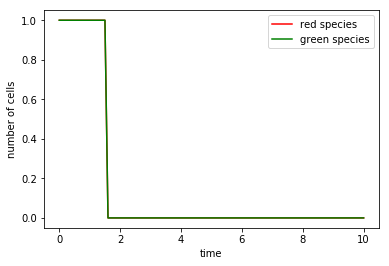

In [6]:
%matplotlib inline
plt.plot(sim.book.n_alive[:,0,0],sim.book.n_alive[:,0,1], color = 'r')
plt.plot(sim.book.n_alive[:,1,0],sim.book.n_alive[:,1,1], color = 'g')
plt.legend(['red species','green species'])
plt.xlabel('time')
plt.ylabel('number of cells')


Text(0.5,1,'Growth curve')

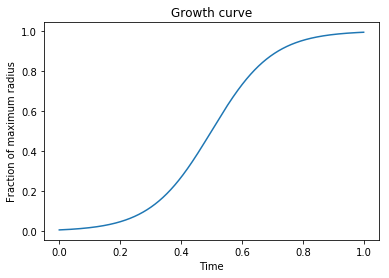

In [694]:
## growth curve

def growthcurve(x, k=10):
    return 1/(1+np.exp(-k*(x-0.5)))

xax = np.linspace(0,1,1000)
y = growthcurve(xax)
plt.plot(xax,y)
plt.xlabel('Time')
plt.ylabel('Fraction of maximum radius')
plt.title('Growth curve')
